In [1]:
import random
import numpy as np
import operator
import math
import pandas as pd
import time
import os
import dill
from sympy import *
from sympy.parsing import sympy_parser

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from scoop import futures
from pandas import DataFrame

from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import multiprocessing as mp

# x(t)=Acos(wt+pi)
#mass=1(kg), k=5 >> w=(k/m)**0.5
#Amplitude=2
#pi=0

#t=np.arange(0,10.01,0.01)



t = np.arange(0,5,0.01)
A=3
pi=3
m=2
k=5
w=(k//m)**0.5
err=np.random.uniform(-1,1, size=(len(t),))/10

f = np.exp(-t)*t + np.exp(-t)
ff = np.exp(-t)*t + np.exp(-t)

table = {'t' : t, 'x' : f}
table_r = {'t' : t, 'x' : ff}

data = DataFrame(table)
data.to_csv("//home//ban94gy//jupyter//ML//exer//END//der//os.csv")

data_r = DataFrame(table_r)
data_r.to_csv("//home//ban94gy//jupyter//ML//exer//END//der//os_r.csv")


plt.plot(t,f,t,ff)
plt.xlabel('time')  # x-axis
plt.ylabel('x(t)')  # y-axis
plt.grid()  # grid
plt.show()  # plot show
    


In [8]:
def plot_pred(hof):
    func = toolbox.compile(expr=hof[0])
    y_hat = []
    y = []
    y_r = []
    for a, i in enumerate(t):
        y_hat.append(func(i))
        y.append(p[a])
        y_r.append(p_r[a])
        
    from matplotlib import pyplot as plt
    plt.plot(t,y)
    plt.plot(t, y_hat)
    plt.plot(t, y_r)
    plt.xlabel('time')  # x-axis
    plt.ylabel('x(t)')  # y-axis
    plt.title('Data')  # title
    plt.grid()  # grid
    plt.legend(['with error','predicted','real'])
    plt.show()  # plot show

###################### Define functions############################
def safeDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
def sqrt(left):
    if left>=0:
        return left**0.5
    else:
        return 0
    
def expe(left):
    if left>=0:
        return np.exp(-left)
    else:
        return 0


pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
#pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(expe, 1)
#set.addPrimitive(safeDiv, 2)
pset.addPrimitive(sqrt,1)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

try:
    pset.addEphemeralConstant("rand",random.randint(1,100)/100)
except:
    print("")

#pset.addEphemeralConstant("rand", lambda: random.randint(1,5))
#pset.addEphemeralConstant("rand"+str(ran1)+str(ran2), lambda: random.randint(min(ran1,ran2),max(ran1,ran2)))
pset.renameArguments(ARG0='x')
###################################################################
pool = mp.Pool()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
#toolbox.register("map", futures.map)

#########################input DATA#################################

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    # Evaluate the mean squared error between the expression
    sqerrors = ((func(x) - f[x])**2 for x in points)

    try:
        return max(sqerrors),
    except IndexError:
        return max(sqerrors),
    
toolbox.register("map", pool.map)


g = pd.read_csv('os.csv')
p = g['x']
g_r = pd.read_csv('os_r.csv')
p_r = g_r['x']


f = {}
for i in range(len(t)):
    f[t[i]] = p[i]
    
ff = {}
for i in range(len(t)):
    ff[t[i]] = p_r[i]
    
    
toolbox.register("evaluate", evalSymbReg, points=t)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))

def main():
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    
    
    #############################################C.O, Muta,Gener##########
    try:
        pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.8, 10, stats=mstats,
                                       halloffame=hof, verbose=True)
        print (hof[0])
        plot_pred(hof)
        return hof
    
    except MemoryError:
        print (hof[0])
        plot_pred(hof)
        return hof
    
    except KeyboardInterrupt:
        print (hof[0])
        plot_pred(hof)
        return hof



if __name__ == "__main__":    
    try:
        hof = main()
    except:
        print("")



/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Process ForkPoolWorker-140:
Process ForkPoolWorker-134:
Process ForkPoolWorker-149:
Process ForkPoolWorker-146:
Process ForkPoolWorker-144:
Process ForkPoolWorker-137:
Process ForkPoolWorker-133:
Process ForkPoolWorker-158:
Process ForkPoolWorker-129:
Process ForkPoolWorker-123:
Process ForkPoolWorker-126:
Process ForkPoolWorker-150:
Process ForkPoolWorker-130:
Process ForkPoolWorker-135:
Process ForkPoolWorker-127:
Process ForkPoolWorker-159:
Process ForkPoolWorker-148:
Process ForkPoolWorker-132:
Process ForkPoolWorker-154:
Process ForkPoolWorker-125:
Process ForkPoolWorker-136:
Process ForkPoolWorker-142:
Process ForkPoolWorker-157:
Process ForkPoolWorker-141:
Process ForkPoolWorker-122:
Process ForkPoolWorker-145:
Process ForkPoolWorker-124:
Process ForkPoolWorker-143:
Process ForkPoolWorker-131:
Process ForkPoolWorker-121:
Process ForkPoolWorker-147:
Process ForkPoolWorker-160:
Process ForkPoolWorker-151:
Process ForkPoolWorker-153:
Process ForkPoolWorker-128:
Process ForkPoolWork

  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", li

  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker


/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	         fitness         	    size   
   	      	-------------------------	-----------
gen	nevals	max        	min      	max	min
0  	20000 	9.53384e+08	0.0193387	14 	2  
1  	19191 	1.36175e+07	1.2326e-32	21 	2  
2  	19168 	6.28663e+06	1.2326e-32	23 	2  


Process ForkPoolWorker-194:
Process ForkPoolWorker-180:
Process ForkPoolWorker-190:
Process ForkPoolWorker-182:
Process ForkPoolWorker-174:


add(expe(x), mul(expe(x), x))


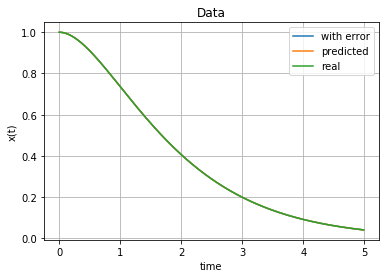

Traceback (most recent call last):
Process ForkPoolWorker-192:
Process ForkPoolWorker-175:
Process ForkPoolWorker-172:
Process ForkPoolWorker-171:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-179:
Process ForkPoolWorker-173:
Process ForkPoolWorker-193:
Process ForkPoolWorker-176:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-163:
Traceback (most recent call last):
Process ForkPoolWorker-184:
Process ForkPoolWorker-181:
Process ForkPoolWorker-199:
Process ForkPoolWorker-195:
Process ForkPoolWorker-191:
Process ForkPoolWorker-185:
Process ForkPoolWorker-198:
Process ForkPoolWorker-177:
Process ForkPoolWorker-196:
Process ForkPoolWorker-165:
Process ForkPoolWorker-161:
Process ForkPoolWorker-166:
Process ForkPoolWorker-164:
Process ForkPoolWorker-178:
Process ForkPoolWorker-183:
  File "/usr/lib/python3.5/multiprocessing/process.py", li

  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in 

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 10

In [9]:
def plot_pred(hof):
    func = toolbox.compile(expr=hof[0])
    y_hat = []
    y = []
    y_r = []
    for a, i in enumerate(t):
        y_hat.append(func(i))
        y.append(p[a])
        y_r.append(p_r[a])
        
    from matplotlib import pyplot as plt
    plt.plot(t,y)
    plt.plot(t, y_hat)
    plt.plot(t, y_r)
    plt.xlabel('time')  # x-axis
    plt.ylabel('x(t)')  # y-axis
    plt.title('Data')  # title
    plt.grid()  # grid
    plt.legend(['with error','predicted','real'])
    plt.show()  # plot show

###################### Define functions############################
def safeDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
def sqrt(left):
    if left>=0:
        return left**0.5
    else:
        return 0
    
def expe(left):
    if left>=0:
        return np.exp(-left)
    else:
        return 0


pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
#pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(expe, 1)
#set.addPrimitive(safeDiv, 2)
pset.addPrimitive(sqrt,1)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

try:
    pset.addEphemeralConstant("rand",random.randint(1,100)/100)
except:
    print("")

#pset.addEphemeralConstant("rand", lambda: random.randint(1,5))
#pset.addEphemeralConstant("rand"+str(ran1)+str(ran2), lambda: random.randint(min(ran1,ran2),max(ran1,ran2)))
pset.renameArguments(ARG0='x')
###################################################################
pool = mp.Pool()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
#toolbox.register("map", futures.map)

#########################input DATA#################################

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    # Evaluate the mean squared error between the expression
    sqerrors = ((func(x) - f[x])**2 for x in points)

    try:
        return max(sqerrors),
    except IndexError:
        return max(sqerrors),
    
toolbox.register("map", pool.map)


g = pd.read_csv('os.csv')
p = g['x']
g_r = pd.read_csv('os_r.csv')
p_r = g_r['x']


f = {}
for i in range(len(t)):
    f[t[i]] = p[i]
    
ff = {}
for i in range(len(t)):
    ff[t[i]] = p_r[i]
    
    
toolbox.register("evaluate", evalSymbReg, points=t)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))



def main():
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    
    
    #############################################C.O, Muta,Gener##########
    try:
        pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.8, 10, stats=mstats,
                                       halloffame=hof, verbose=True)
        print (hof[0])
        plot_pred(hof)
        return hof
    
    except MemoryError:
        print (hof[0])
        plot_pred(hof)
        return hof
    
    except KeyboardInterrupt:
        print (hof[0])
        plot_pred(hof)
        return hof



if __name__ == "__main__":    
    hof = main()
    


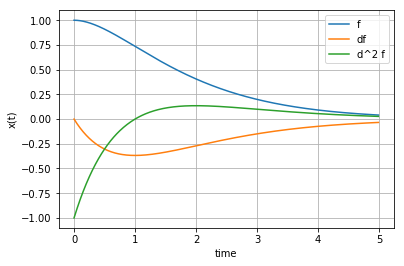

In [10]:
from sympy.parsing import sympy_parser

x = Symbol('x')

def add(a,b):
    return a+b

def expe(a):
    return exp(-a)

def mul(a,b):
    return a*b

def neg(a):
    return -a

def sqrt(a):
    return a**0.5

expr_dict = {'add':add, 'expe':expe, 'mul':mul,'neg':neg,'sqrt':sqrt}

d = sympy_parser.parse_expr(str(hof[0]), local_dict=expr_dict)
d1 = diff(d,x)
d2 = diff(d1,x)


y = lambdify(x,d)
y1 = lambdify(x,d1)
y2 = lambdify(x,d2)


f = y(t)
f1 = y1(t)
f2 = y2(t)

plt.plot(t,f,t,f1,t,f2)
plt.xlabel('time')  # x-axis
plt.ylabel('x(t)')  # y-axis
plt.legend(['f','df','d^2 f'])
plt.grid()  # grid
plt.show()  # plot show

table = {'t' : t, 'x' : f}
table_r = {'t' : t, 'x' : f1}
table_rr = {'t' : t, 'x' : f2}


data = DataFrame(table)
data.to_csv("//home//ban94gy//jupyter//ML//exer//END//der//os_f.csv")

data_r = DataFrame(table_r)
data_r.to_csv("//home//ban94gy//jupyter//ML//exer//END//der//os_df.csv")

data_rr = DataFrame(table_rr)
data_rr.to_csv("//home//ban94gy//jupyter//ML//exer//END//der//os_ddf.csv")


In [11]:
###################### Define functions############################
def sqrt(left):
    if left>=0:
        return left**0.5
    else:
        return 0


    
pset = gp.PrimitiveSet("MAIN", 2) 
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(operator.mul, 2)
try:
    pset.addEphemeralConstant("rand", random.randint(1,100)/100)
except:
    print("")
    
#pset.addEphemeralConstant("rand", lambda: random.randint(1,5))
#pset.addEphemeralConstant("rand"+str(ran1)+str(ran2), lambda: random.randint(min(ran1,ran2),max(ran1,ran2)))
pset.renameArguments(ARG0='f1')
pset.renameArguments(ARG1='f2')

In [12]:
###################################################################

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
# toolbox.register("map", futures.map)

#########################input DATA#################################

def evalSymbReg(individual, points):
    
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    # Evaluate the mean squared error between the expression
    sqerrors = ((func(f1,f2) + f)**2 for f,f1,f2 in points)
    
    try:
        return max(sqerrors),
    except IndexError:
        return max(sqerrors),
    
    

g = pd.read_csv('os_f.csv')
p = g['x']
g1 = pd.read_csv('os_df.csv')
p1 = g1['x']
g2 = pd.read_csv('os_ddf.csv')
p2 = g2['x']
pool = mp.Pool()

f = {}
f1 = {}
f2 = {}


for i in range(len(t)):
    f[i] = p[i]
    f1[i] = p1[i]
    f2[i] = p2[i]

pts = []
for i in range(len(t)):
    pts.append((f[i], f1[i], f2[i]))
    
toolbox.register("evaluate", evalSymbReg, points=pts)

toolbox.register("map", pool.map)

toolbox.register("select", tools.selTournament, tournsize=100)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=4))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=4))


def main():
    
    pop = toolbox.population(n=10000)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    
    #############################################C.O, Muta,Gener##########
    try:
        pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.8, 10, stats=mstats,
                                       halloffame=hof, verbose=True)
        print (hof[0])
        return hof

    except MemoryError:
        print (hof[0])
        return hof

    except KeyboardInterrupt:                                                                                                        
        print (hof[0])
        return hof


if __name__ == "__main__":
    hof = main()

/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	      fitness      	    size   
   	      	-------------------	-----------
gen	nevals	max	min        	max	min
0  	10000 	49 	1.10934e-31	15 	2  
1  	9609  	81 	1.10934e-31	23 	2  
2  	9625  	25 	1.10934e-31	24 	2  


Process ForkPoolWorker-432:


add(f1, add(f1, f2))


Process ForkPoolWorker-417:
Process ForkPoolWorker-430:
Process ForkPoolWorker-407:
Process ForkPoolWorker-428:
Process ForkPoolWorker-412:
Process ForkPoolWorker-438:
Process ForkPoolWorker-434:
Process ForkPoolWorker-408:
Process ForkPoolWorker-425:
Process ForkPoolWorker-404:
Process ForkPoolWorker-437:
Process ForkPoolWorker-424:
Process ForkPoolWorker-406:
Process ForkPoolWorker-431:
Process ForkPoolWorker-418:
Process ForkPoolWorker-414:
Process ForkPoolWorker-426:
Process ForkPoolWorker-435:
Process ForkPoolWorker-420:
Traceback (most recent call last):
Process ForkPoolWorker-415:
Process ForkPoolWorker-436:
Process ForkPoolWorker-410:
Process ForkPoolWorker-411:
Process ForkPoolWorker-422:
Process ForkPoolWorker-440:
Process ForkPoolWorker-433:
Process ForkPoolWorker-402:
Process ForkPoolWorker-405:
Process ForkPoolWorker-401:
Process ForkPoolWorker-419:
Traceback (most recent call last):
Process ForkPoolWorker-416:
Process ForkPoolWorker-429:
Process ForkPoolWorker-403:
Proces

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in 

  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/pytho

In [13]:
def add(a,b):
    return a+b

def expe(a):
    return exp(-a)

def mul(a,b):
    return a*b

def sub(a,b):
    return a-b

def neg(a):
    return -a

f1 = Symbol('f1')
f2 = Symbol('f2')

expr_dict = {'add':add, 'expe':expe, 'mul':mul,'neg':neg,'sqrt':sqrt}

dif_eq = sympy_parser.parse_expr(str(hof[0]), local_dict=expr_dict)
print("The solution of the motion is ",d)
print("The differential equation is >> f + ",dif_eq,"= 0!!(f1=df/dt, f2=d^2f/df^2)")


The solution of the motion is  x*exp(-x) + exp(-x)
The differential equation is >> f +  2*f1 + f2 = 0!!


In [8]:
from sympy import *
from sympy.parsing import sympy_parser

f1 = Symbol('f1')
f2 = Symbol('f2')

def safeDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
safeDiv(f1,f2)

f1/f2